In [37]:
import os
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.image as mpimg
from torch.utils.data import Dataset
from torchvision import transforms, utils
import torchvision.transforms as transforms
import cv2

%matplotlib inline

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Input

In [38]:

class PokerDataset(Dataset): 
    def __init__(self,root,train,transform): 
        self.transform = transform
        self.image_files = []
        if train:
            dic = 'training'
        else:
            dic = 'testing'
        for label in os.listdir(root+dic): 
            for r, _, f in os.walk(root+dic+'/'+label):
                for item in range(len(f)):
                    self.image_files.append((r+'/'+f[item],int(label)))

    def __getitem__(self, index):    
        img_name, label = self.image_files[index]
        img = mpimg.imread(img_name)
        img = transforms.ToTensor()(np.array(img))
        return[img,label]

    def __len__(self): 
        return len(self.image_files)
    
transform = transforms.Compose([transforms.ToTensor()])
img,label = PokerDataset('./pca_poker_data/',True,transform).__getitem__(51)

print(type(img))
print(np.shape(img))
tempimg = np.zeros((96,71))
for i in range (96):
    for j in range (71):
        tempimg[i,j] = img[0,i,j]

<class 'torch.Tensor'>
torch.Size([1, 96, 71])


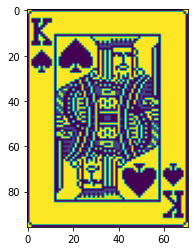

In [39]:
plt.figure()
plt.imshow(tempimg)
batchSize=13

In [5]:
print(type(img))
print(img)

<class 'torch.Tensor'>
tensor([[[1., 1., 0.,  ..., 0., 1., 1.],
         [1., 0., 1.,  ..., 1., 0., 1.],
         [0., 1., 1.,  ..., 1., 1., 0.],
         ...,
         [0., 1., 1.,  ..., 1., 1., 0.],
         [1., 0., 1.,  ..., 1., 0., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.]]])


In [40]:
trainset = PokerDataset('./pca_poker_data/',train=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True)

testset = PokerDataset('./pca_poker_data/',train=False,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=True)

In [41]:
classes = ('0', '1', '2', '3')

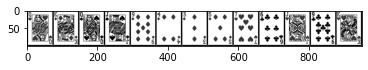

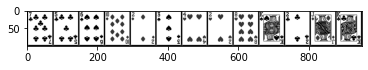

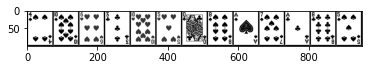

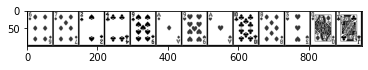

In [42]:
def show_batch(data):
    imgs = data[0]
    grid = utils.make_grid(imgs,nrow=batchSize)
#     print(grid.numpy().shape)
#     print(grid.numpy().transpose((1, 2, 0)).shape)

    plt.figure()
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('')

for i, data in enumerate(testloader):
    if(i<4):
        show_batch(data)
    else:
        break

# Net

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6816, 512)
        self.fc2 = nn.Linear(512, 100)
        self.fc3 = nn.Linear(100, 4)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b,c,h,w = x.size()
        x = x.view(b,c*h*w)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

net = Net()

In [44]:
for p in enumerate(net.parameters()):
    print(p[1].size())

torch.Size([512, 6816])
torch.Size([512])
torch.Size([100, 512])
torch.Size([100])
torch.Size([4, 100])
torch.Size([4])


# Loss and optimizer

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training
https://www.runoob.com/python/python-func-enumerate.html

In [65]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #print(labels)
        #print(outputs)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.10f' % (epoch+1 , i , running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,     0] loss: 0.0006652420
[2,     0] loss: 0.0006754526
[3,     0] loss: 0.0006742942
[4,     0] loss: 0.0006769364
[5,     0] loss: 0.0006817207
[6,     0] loss: 0.0006822343
[7,     0] loss: 0.0006707187
[8,     0] loss: 0.0006797337
[9,     0] loss: 0.0006762011
[10,     0] loss: 0.0006767654
Finished Training


# Save Weight

In [66]:
w_path = './w_poker_net.pth'
m_path = './m_poker_net.pth'
torch.save(net.state_dict(), w_path)
torch.save(net, m_path)

# Load Weight

In [67]:
net = Net()
net.load_state_dict(torch.load(w_path))

<All keys matched successfully>

# Testing
https://www.runoob.com/python/python-func-iter.html
torch.max(input, dim, keepdim=False, out=None)

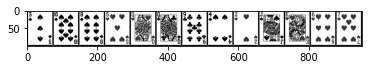

In [68]:
dataiter = iter(testloader)
data = dataiter.next()
images, labels = data
show_batch(data)

In [69]:
outputs = net(images)
outputs.size()

torch.Size([13, 4])

In [70]:
_, predicted = torch.max(outputs, 1)
print(_)
print(predicted)

tensor([0.5721, 0.5597, 0.5478, 0.5696, 0.5416, 0.5179, 0.5726, 0.5512, 0.6046,
        0.5561, 0.5527, 0.5589, 0.5703], grad_fn=<MaxBackward0>)
tensor([1, 3, 3, 1, 1, 1, 0, 1, 1, 3, 2, 1, 1])


In [71]:
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(13)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(13)))

GroundTruth:      3     3     3     2     2     0     0     3     2     3     2     2     2
Predicted:      1     3     3     1     1     1     0     1     1     3     2     1     1


In [64]:
correct = 0
total = 52
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)      
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


In [ ]:
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = net(images)
#         _, predicted = torch.max(outputs, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(4):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1

# for i in range(10):
#     print('Accuracy of %5s : %2d %%' % (
#         classes[i], 100 * class_correct[i] / class_total[i]))